Validation of the pp equilibrium against the Fokker-Plank equation solution 
===========================================================================

Jet pp
------

In [1]:
from jetset.jet_model import Jet
from jetset.jetkernel import jetkernel
from astropy import constants as const
from jetset.jet_emitters_factory import EmittersFactory
from jetset.jet_emitters import InjEmittersArrayDistribution
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_component(j_name,nu_name):
    j_nu_ptr=getattr(j._blob,j_name)
    nu_ptr=getattr(j._blob,nu_name)
    xg=np.zeros(j._blob.nu_grid_size)
    yg=np.zeros(j._blob.nu_grid_size)
    for i in range(j._blob.nu_grid_size):
        xg[i]=jetkernel.get_spectral_array(nu_ptr,j._blob,i)
        yg[i]=jetkernel.get_spectral_array(j_nu_ptr,j._blob,i)
    
    m=yg>0

    xg=xg[m]
    yg=yg[m]
    yg=yg*xg
    yg=yg*jetkernel.erg_to_TeV

    xg=xg*jetkernel.HPLANCK_TeV
    
    return xg,yg



In [3]:
import jetset
print('tested on jetset',jetset.__version__)

tested on jetset 1.2.0


In [4]:
j=Jet(emitters_distribution='plc',verbose=False,emitters_type='protons')

In [5]:

j.parameters.z_cosm.val=z=0.001
j.parameters.beam_obj.val=1
j.parameters.gamma_cut.val=1000/(jetkernel.MPC2_TeV)
j.parameters.NH_pp.val=1
j.parameters.N.val=1
j.parameters.p.val=2.0
j.parameters.B.val=.5
j.parameters.R.val=1E18
j.parameters.gmin.val=1
j.parameters.gmax.val=1E4
j.set_emiss_lim(1E-60)
j.set_IC_nu_size(100)
j.gamma_grid_size=200
j.eval()


In [6]:
gmin=1.0/jetkernel.MPC2_TeV
j.set_N_from_U_emitters(1.0, gmin=gmin)
j.eval()

#j.show_model()

m=j.emitters_distribution.gamma_p>gmin
print('U N(p) p>1 TeV=%e erg/cm-3'%(jetkernel.MPC2*np.trapz(j.emitters_distribution.n_gamma_p[m]*j.emitters_distribution.gamma_p[m],j.emitters_distribution.gamma_p[m])))

U N(p) p>1 TeV=9.999992e-01 erg/cm-3


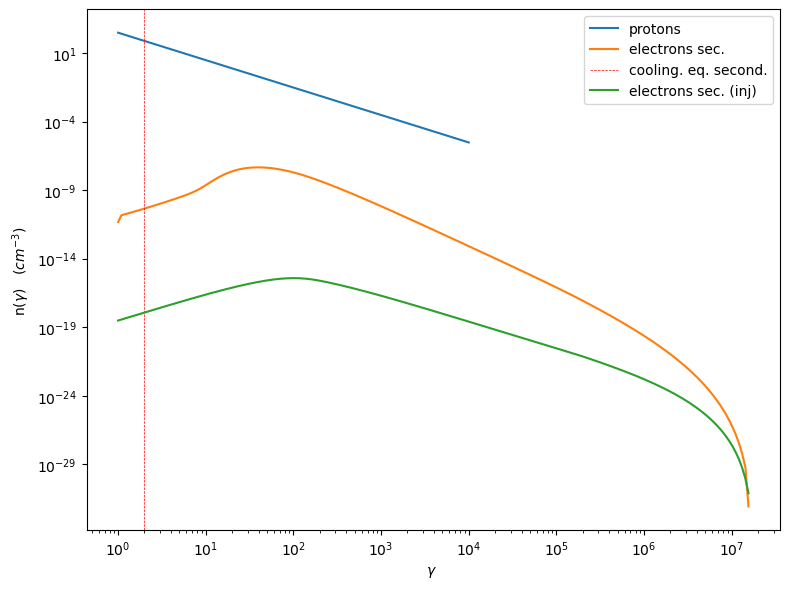

In [7]:
%matplotlib inline
j.emitters_distribution.plot()

In [8]:
j.save_model('hadronic.pkl')

In [9]:
from jetset.jet_model import Jet
j=Jet.load_model('hadronic.pkl')

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_hadronic_pp,gmin,low-energy-cut-off,lorentz-factor*,1.000000e+00,1.000000e+00,1.000000e+09,False,False
jet_hadronic_pp,gmax,high-energy-cut-off,lorentz-factor*,1.000000e+04,1.000000e+00,1.000000e+15,False,False
jet_hadronic_pp,N,emitters_density,1 / cm3,3.022554e+02,0.000000e+00,--,False,False
jet_hadronic_pp,NH_pp,target_density,1 / cm3,1.000000e+00,0.000000e+00,--,False,False
jet_hadronic_pp,gamma_cut,turn-over-energy,lorentz-factor*,1.065789e+06,1.000000e+00,1.000000e+09,False,False
jet_hadronic_pp,p,LE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False
jet_hadronic_pp,R,region_size,cm,1.000000e+18,1.000000e+03,1.000000e+30,False,False
jet_hadronic_pp,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_hadronic_pp,B,magnetic_field,gauss,5.000000e-01,0.000000e+00,--,False,False
jet_hadronic_pp,beam_obj,beaming,lorentz-factor*,1.000000e+00,1.000000e-04,--,False,False


setting up the JetTimeEvol model
--------------------------------

In [10]:
gamma_sec_evovled=np.copy(j.emitters_distribution.gamma_e)
n_gamma_sec_evovled=np.copy(j.emitters_distribution.n_gamma_e)
gamma_sec_inj=np.copy(j.emitters_distribution.gamma_e_second_inj)
n_gamma_sec_inj=np.copy(j.emitters_distribution.n_gamma_e_second_inj)

In [11]:
from jetset.jet_emitters_factory import EmittersFactory
from jetset.jet_emitters import InjEmittersArrayDistribution
q_inj=InjEmittersArrayDistribution(name='array_distr',emitters_type='electrons',gamma_array=gamma_sec_inj,n_gamma_array=n_gamma_sec_inj,normalize=False)

In [12]:
q_inj.parameters

name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
gmin,low-energy-cut-off,lorentz-factor*,1.000000e+00,1.000000e+00,1.000000e+09,False,False
gmax,high-energy-cut-off,lorentz-factor*,1.836150e+07,1.000000e+00,1.000000e+15,False,False
Q,emitters_density,1 / (cm3 s),1.000000e+00,0.000000e+00,--,False,False


None

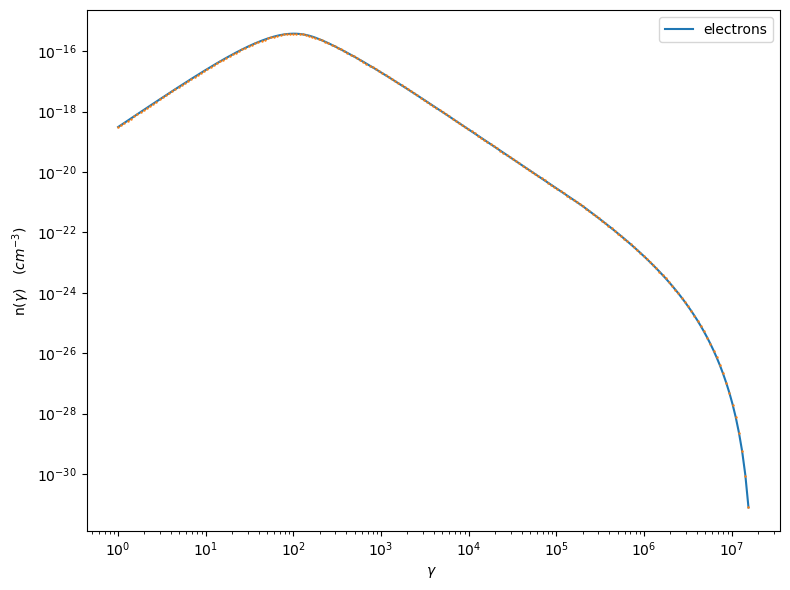

In [13]:
%matplotlib inline
p=q_inj.plot()
p.ax.plot(gamma_sec_inj, n_gamma_sec_inj,'.',ms=1.5)



In [14]:
from jetset.jet_timedep import JetTimeEvol
from jetset.jet_model import Jet

temp_ev=JetTimeEvol(jet_rad=j,Q_inj=q_inj,only_radiation=True,inplace=True)

/Users/orion/anaconda3/envs/jetset/lib/python3.8/site-packages/jetset/model_manager.py:147: UserWarning: no cosmology defined, using default FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0483)
  warnings.warn('no cosmology defined, using default %s'%self.cosmo)


In [15]:
temp_ev.Q_inj.parameters.Q.val

1

we use the acc region with escape time equal to radiative region

In [16]:
duration=5E9
duration_acc=0
T_SIZE=np.int(2E6)

temp_ev.parameters.duration.val=duration

temp_ev.parameters.TStart_Inj.val=0
temp_ev.parameters.TStop_Inj.val=duration
temp_ev.parameters.T_esc_rad.val= 1


temp_ev.parameters.Esc_Index_rad.val=0
temp_ev.parameters.t_size.val=T_SIZE
temp_ev.parameters.num_samples.val=500
temp_ev.IC_cooling='off'
temp_ev.parameters.L_inj.val=0

temp_ev.parameters.gmin_grid.val=1.1
temp_ev.parameters.gmax_grid.val=5E7
temp_ev.parameters.gamma_grid_size.val=400

temp_ev.init_TempEv()
temp_ev.region_expansion='off'
temp_ev.show_model()

--------------------------------------------------------------------------------
JetTimeEvol model description
--------------------------------------------------------------------------------
 
physical setup: 

--------------------------------------------------------------------------------


name,par type,val,units,val*,units*,log
delta t,time,2.500000e+03,s,7.494811449999999e-05,R/c,False
log. sampling,time,0.000000e+00,,None,,False
R/c,time,3.335641e+07,s,1.0,R/c,False
IC cooling,,off,,None,,False
Sync cooling,,on,,None,,False
Adiab. cooling,,on,,None,,False
Reg. expansion,,off,,None,,False
Tesc rad,time,3.335641e+07,s,1.0,R/c,False
R_rad rad start,region_position,1.000000e+18,cm,None,,False
R_H rad start,region_position,1.000000e+17,cm,None,,False



model parameters: 

--------------------------------------------------------------------------------


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_time_ev,duration,time_grid,s,5.000000e+09,0.000000e+00,--,False,True
jet_time_ev,gmin_grid,gamma_grid,,1.100000e+00,0.000000e+00,--,False,True
jet_time_ev,gmax_grid,gamma_grid,,5.000000e+07,0.000000e+00,--,False,True
jet_time_ev,gamma_grid_size,gamma_grid,,4.000000e+02,0.000000e+00,--,False,True
jet_time_ev,TStart_Inj,time_grid,s,0.000000e+00,0.000000e+00,--,False,True
jet_time_ev,TStop_Inj,time_grid,s,5.000000e+09,0.000000e+00,--,False,True
jet_time_ev,T_esc_rad,escape_time,(R/c)*,1.000000e+00,--,--,False,True
jet_time_ev,Esc_Index_rad,fp_coeff_index,,0.000000e+00,--,--,False,True
jet_time_ev,R_rad_start,region_size,cm,1.000000e+18,0.000000e+00,--,False,True
jet_time_ev,R_H_rad_start,region_position,cm,1.000000e+17,0.000000e+00,--,False,True


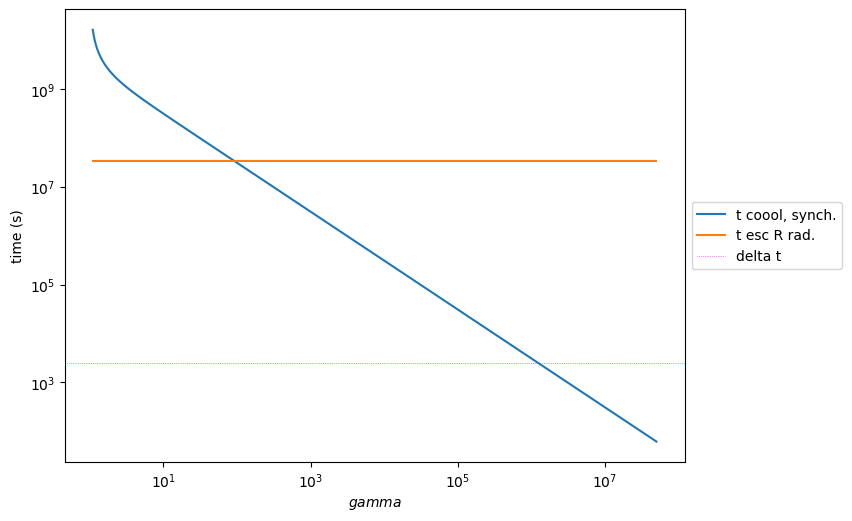

In [17]:
p=temp_ev.plot_pre_run_plot(dpi=100)


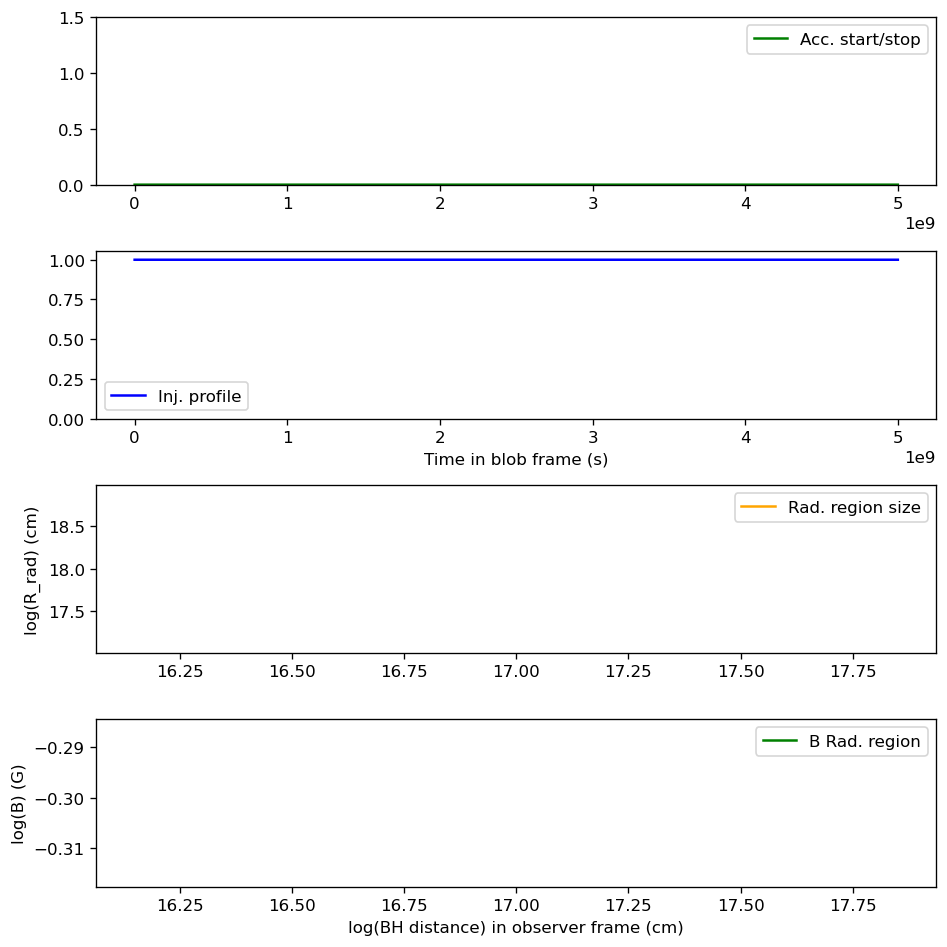

In [18]:
p=temp_ev.plot_time_profile()

In [19]:
temp_ev.run(only_injection=True,cache_SEDs_acc=False,do_injection=True,cache_SEDs_rad=False)


temporal evolution running


  0%|          | 0/2000000 [00:00<?, ?it/s]

temporal evolution completed


we use the acc region with escape time equal to radiative region

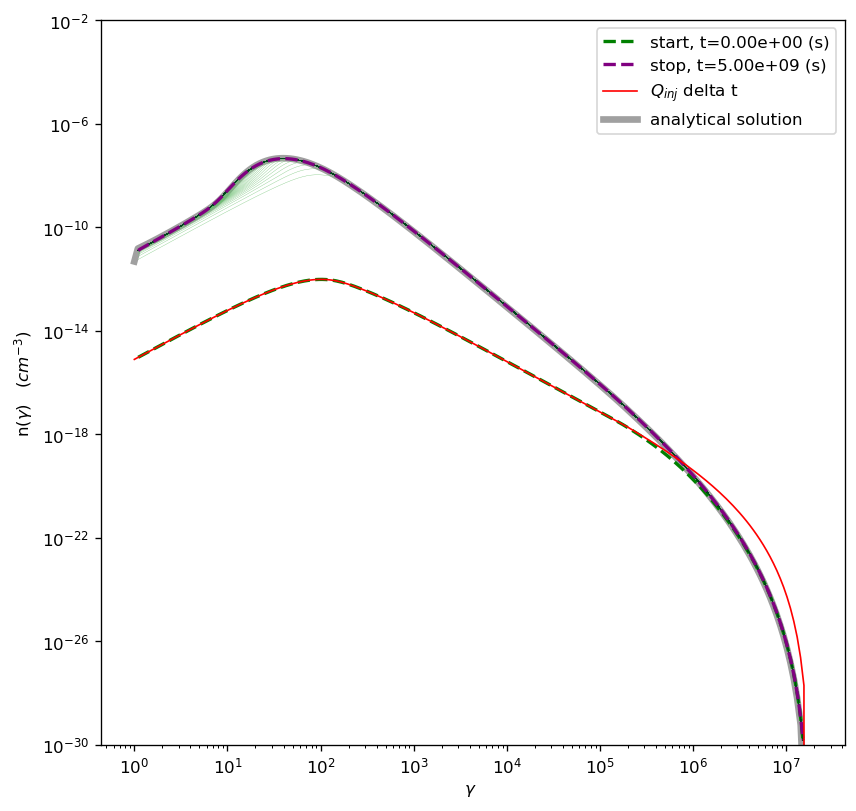

In [20]:
p=temp_ev.plot_tempev_emitters(region='rad',loglog=False,energy_unit='gamma',pow=0,plot_Q_inj=True)
p.ax.plot(gamma_sec_evovled,n_gamma_sec_evovled,'-',label='analytical solution',lw=4,color='gray',alpha=0.75,zorder=0)
p.ax.legend()
p.setlim(y_min=1E-30,y_max=1E-2)


In [21]:
m=n_gamma_sec_evovled>0
x_analytical=np.log10(gamma_sec_evovled[m])
y_analytical=np.log10(n_gamma_sec_evovled[m])

m=temp_ev.rad_region.time_sampled_emitters.n_gamma[-1]>0
x_num=np.log10(temp_ev.rad_region.time_sampled_emitters.gamma[m])
y_num=np.log10(temp_ev.rad_region.time_sampled_emitters.n_gamma[-1][m])

y_analytical_interp = np.interp(x_num, x_analytical,y_analytical, left=np.nan, right=np.nan)

m=~np.isnan(y_analytical_interp)
m=np.logical_and(m,x_num>0.25)
m=np.logical_and(m,x_num<6)

y_analytical_interp=10**y_analytical_interp[m]
x_out=x_num[m]
y_num=10**y_num[m]

In [22]:

d=np.fabs(y_analytical_interp-y_num)/y_num
assert(all(d<0.25))

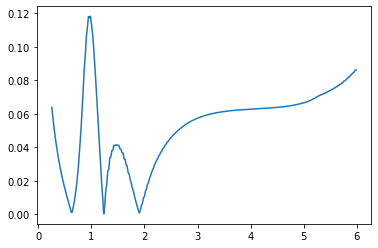

In [23]:
plt.plot(x_out,d)